1) Setup - installs

In [5]:
!pip install -q imbalanced-learn xgboost
!pip install kagglehub[pandas-datasets]

2) Imports

In [6]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Try/except for XGBoost since it may not be installed by default
try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

# For handling imbalance
from imblearn.over_sampling import SMOTE

3) Load data & quick checks

In [7]:
# Adjust path if needed
# DATA_PATH = '/kaggle/input/creditcardfraud/creditcard.csv'
# data = pd.read_csv(DATA_PATH)

import kagglehub
import os

# Download the dataset from KaggleHub
dataset_url = "mlg-ulb/creditcardfraud"
dataset_path = kagglehub.dataset_download(dataset_url)

# List files in the downloaded directory to verify the path and filename
print("Files in downloaded dataset directory:")
for root, dirs, files in os.walk(dataset_path):
    for name in files:
        print(os.path.join(root, name))

# Construct the full path to the CSV file within the downloaded dataset
# Assuming the file is directly in the downloaded path based on typical dataset structures
file_path = os.path.join(dataset_path, 'creditcard.csv')

# Load the dataset from the downloaded path
data = pd.read_csv(file_path)


print('Shape:', data.shape)
print('\nColumns:', data.columns.tolist())

# Quick peek
display(data.head())

# Basic info
print('\nInfo:')
print(data.info())

print('\nMissing values per column:')
print(data.isnull().sum().sort_values(ascending=False).head())

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Files in downloaded dataset directory:
/kaggle/input/creditcardfraud/creditcard.csv
Shape: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21

Target distribution (class imbalance)

Class
0    284315
1       492
Name: count, dtype: int64

Proportions:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


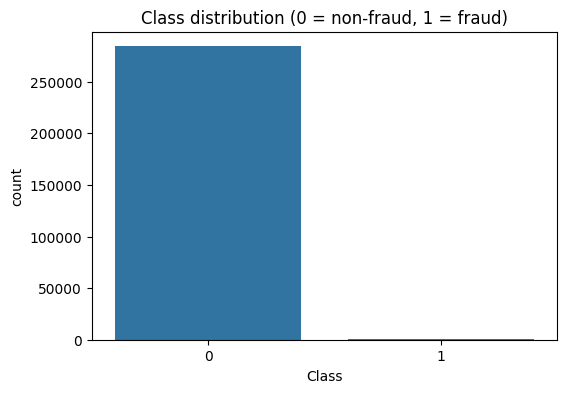

In [8]:
print(data['Class'].value_counts())
print('\nProportions:')
print(data['Class'].value_counts(normalize=True))

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class distribution (0 = non-fraud, 1 = fraud)')
plt.show()

4) Exploratory Data Analysis (EDA)

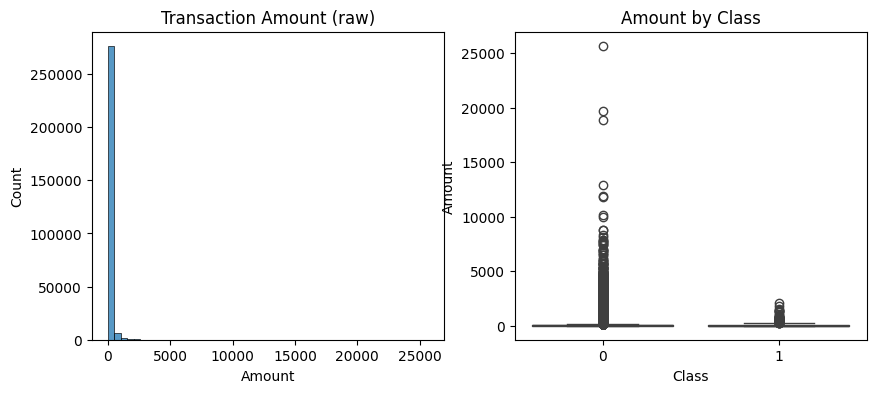

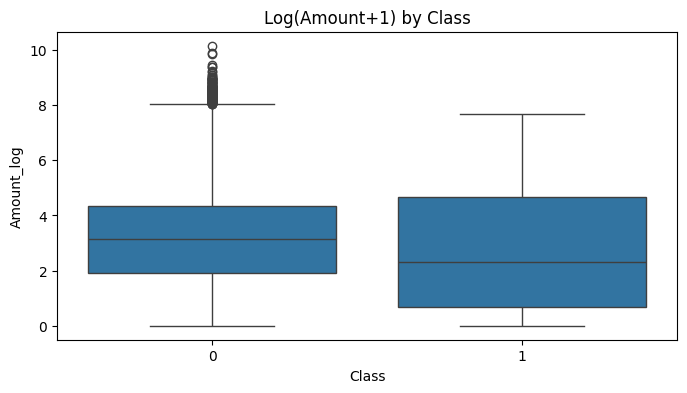

In [9]:
# Amount distribution
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data['Amount'], bins=50, kde=False)
plt.title('Transaction Amount (raw)')

plt.subplot(1,2,2)
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Amount by Class')
plt.show()

# Log-transformed Amount (optional, helps models)
data['Amount_log'] = np.log1p(data['Amount'])
plt.figure(figsize=(8,4))
sns.boxplot(x='Class', y='Amount_log', data=data)
plt.title('Log(Amount+1) by Class')
plt.show()

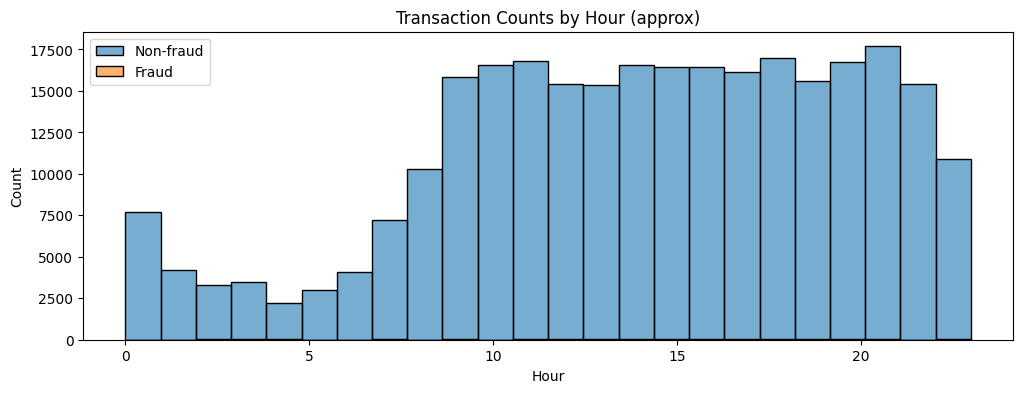

In [10]:
# Time: convert seconds to hours-of-day roughly (if you want to look for time-of-day patterns).
# Note: 'Time' is seconds elapsed between each transaction and the first transaction in the dataset.
# We will look at simple distribution splits.

data['Hour'] = (data['Time'] // 3600) % 24
plt.figure(figsize=(12,4))
sns.histplot(data[data['Class']==0]['Hour'], label='Non-fraud', stat='count', bins=24, alpha=0.6)
sns.histplot(data[data['Class']==1]['Hour'], label='Fraud', stat='count', bins=24, alpha=0.6)
plt.legend()
plt.title('Transaction Counts by Hour (approx)')
plt.show()

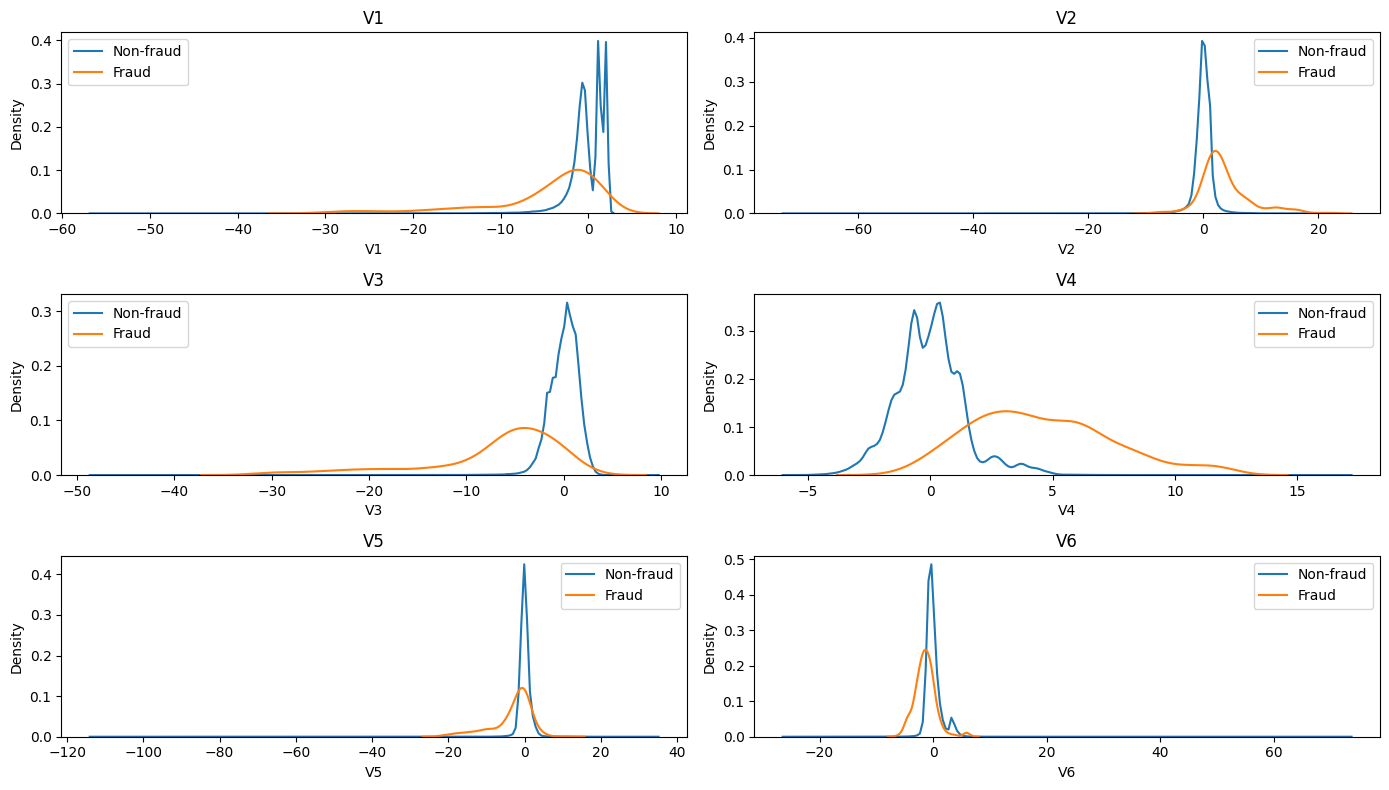

In [11]:
# Compare a few PCA components distributions between classes
pca_cols = [c for c in data.columns if c.startswith('V')][:6]  # show first 6 for brevity
plt.figure(figsize=(14,8))
for i, col in enumerate(pca_cols, 1):
    plt.subplot(3,2,i)
    sns.kdeplot(data.loc[data['Class']==0, col], label='Non-fraud', common_norm=False)
    sns.kdeplot(data.loc[data['Class']==1, col], label='Fraud', common_norm=False)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Correlation matrix — we will look at correlation with Class only to keep it readable
corr_with_class = data.corr()['Class'].sort_values(ascending=False)
print('Top correlations with Class:')
print(corr_with_class.head(10))
print('\nLowest correlations with Class:')
print(corr_with_class.tail(10))

Top correlations with Class:
Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64

Lowest correlations with Class:
V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


5) Preprocessing & feature engineering

In [14]:
FEATURES = [c for c in data.columns if c not in ['Class', 'Time']]
TARGET = 'Class'

X = data[FEATURES]
y = data[TARGET]
# Standardize 'Amount_log' and optionally 'Hour' (hours are cyclic but this is a simple approach)
scaler = StandardScaler()
X[['Amount_log', 'Hour']] = scaler.fit_transform(X[['Amount_log', 'Hour']])

print('Feature matrix shape:', X.shape)

Feature matrix shape: (284807, 31)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print('Train class distribution:')
print(y_train.value_counts(normalize=True))
print('\nTest class distribution:')
print(y_test.value_counts(normalize=True))

# Apply SMOTE on training data
smote = SMOTE(random_state=42, sampling_strategy='auto')  # will oversample minority to match majority
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print('\nAfter SMOTE - train distribution:')
print(pd.Series(y_train_res).value_counts())


Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64

After SMOTE - train distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


In [20]:
#Converting the data into a 3D Tensor for CNN
# Citation:(Meet, 2020)
from sklearn.preprocessing import StandardScaler

scaler_cnn = StandardScaler()
X_train_res_scaled = scaler_cnn.fit_transform(X_train_res)
X_test_scaled = scaler_cnn.transform(X_test)

n_features = X_train_res_scaled.shape[1]
X_train_cnn = X_train_res_scaled.reshape(-1, n_features, 1)
X_test_cnn = X_test_scaled.reshape(-1, n_features,1)



In [25]:
# Model Definition
# Citation:(Meet, 2020)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dropout, Dense

# import and build model (Kaggle-style)
model = Sequential()

# first conv block
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))

# second conv block
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())

# dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 29, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 12, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,945 (42.75 KB)

 Trainable params: 10,753 (42.00 KB)

 Non-trainable params: 192 (768.00 B)

In [26]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=[keras.metrics.AUC(name="auc")]
)

In [28]:
# Training Set
history = model.fit(
    X_train_cnn, y_train_res,
    epochs=30,
    batch_size=2048,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - auc: 0.8483 - loss: 0.5065 - val_auc: 0.0000e+00 - val_loss: 0.1633
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - auc: 0.9850 - loss: 0.1305 - val_auc: 0.0000e+00 - val_loss: 0.0443
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - auc: 0.9917 - loss: 0.0948 - val_auc: 0.0000e+00 - val_loss: 0.0479
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - auc: 0.9948 - loss: 0.0767 - val_auc: 0.0000e+00 - val_loss: 0.0404
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - auc: 0.9965 - loss: 0.0648 - val_auc: 0.0000e+00 - val_loss: 0.0341
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - auc: 0.9975 - loss: 0.0555 - val_auc: 0.0000e+00 - val_loss: 0.0222
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 42s 156ms/step - auc: 0.9980 - loss: 0.0490 - val_auc: 0.0000e+00 - val_loss: 0.0243
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - auc: 0.9983 - loss: 0.0439 - val_auc: 0.0000e+00 - val_loss: 0.0165


In [29]:
#Light evaluation
test_loss, test_acc = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9468
